In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### 159731 Mini-project: Corner Detection
# <center>Corner Detection With OpenCV</center>

<center>Yonggang Li 18043158</center>

# install opencv
* !pip install --upgrade pip
* !pip install opencv_python 
* !pip install opencv-contrib-python
* cv2.__version__


### Import the library

In [1]:
import cv2
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta

from matplotlib import pyplot as plt
%matplotlib inline

### Functions for utilities and Moravec, Harris, and FAST algorithms

#### Load image and convert to gray scale

In [2]:
def elapsed_time(start):
    return timedelta(seconds=timer()-start)
    
def print_kps(keyPoints):
    for i in range(len(keyPoints)):
        pt = keyPoints[i].pt
        print("{},{}".format(pt[0], pt[1]))
        
def add_noise(img):
    img_rows = img.shape[0]
    img_cols = img.shape[1]

    WIN_SIZE = 10
    for y in range(0, img_rows-WIN_SIZE, WIN_SIZE):
        for x in range(0, img_cols-WIN_SIZE, WIN_SIZE):
            pos = random.randint(1, WIN_SIZE-1)
            img[y+pos, x+pos] = 168   
            img[y+pos-1, x+pos] = 168
            
# load the specified image and returns: original image, gray images, width, height
def load_img(filename):
    origin = cv2.imread(filename, cv2.IMREAD_COLOR) #IMREAD_UNCHANGED
    gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    print("width: {}, height: {} ".format(gray.shape[1], gray.shape[0]))
    return origin, gray

#### Harris Detector
* blockSize=4, ksize=3, k=0.04
* threshold*dst.max()

In [3]:
# harris detection and return a list of KeyPoint
def harris_detect (gray_img, threshold):
    s_time = timer()
    gray = np.float32(gray_img)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)  
    print("Harris max = {}".format(dst.max()))
    ret, dst = cv2.threshold(dst, threshold*dst.max(), 255, 0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    print("corners type is {}".format(type(corners[0])))
    keyPoints = []
    for i in range(1, len(corners)):
        keyPoints.append(cv2.KeyPoint(corners[i][0], corners[i][1], 8))
    return keyPoints, elapsed_time(s_time)

#### FAST Detector

In [8]:
def fast_detect(gray_img, threshold):
    s_time = timer()
    fast = cv2.FastFeatureDetector_create()
    fast.setThreshold(threshold)
    fast.setNonmaxSuppression(1)
    # Print all default params
    print( "Threshold: {}".format(fast.getThreshold()) )
    print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
    print( "neighborhood: {}".format(fast.getType()) )
    keyPoints = fast.detect(gray_img, None)
    return keyPoints, elapsed_time(s_time)

#### Movravec Detector

In [4]:
# Four directions
def moravec_4(gray_img, factor):
    s_time = timer()
    keyPoints = []
    minMat = np.zeros(gray_img.shape, np.uint32)
    img_rows = gray_img.shape[0]
    img_cols = gray_img.shape[1]

    WIN_SIZE = 5
    HALF_WIN_SIZE = WIN_SIZE / 2
    for y in range(HALF_WIN_SIZE, img_rows-HALF_WIN_SIZE, 1):
        for x in range(HALF_WIN_SIZE, img_cols-HALF_WIN_SIZE, 1):
            d = [0 for i in range(0, 8)]
            for winx in range(-HALF_WIN_SIZE, HALF_WIN_SIZE):
                # 0  degree direction (1, 0)
                d[0] += pow(int(gray_img[y, x+winx+1]) - int(gray_img[y, x+winx]), 2)
                # 45 degree direction (1, 1)
                d[1] += pow( int(gray_img[y+winx+1, x+winx+1]) - int(gray_img[y+winx, x+winx]), 2 );
                # 90 degree direction (0, 1)
                d[2] += pow( int(gray_img[y+winx+1, x]) - int(gray_img[y+winx, x]), 2 );
                # 145 degree direction (-1, 1)
                d[3] += pow( int(gray_img[y+winx+1, x-winx-1]) - int(gray_img[y+winx, x-winx]), 2 );
            minMat[y, x] = min(min(d[0], d[1]), min(d[2], d[3]))
    print("Moravec max = {}".format(minMat.max()))
    threshold = factor*minMat.max()
    for y in range(HALF_WIN_SIZE, img_rows-HALF_WIN_SIZE, HALF_WIN_SIZE):
        for x in range(HALF_WIN_SIZE, img_cols-HALF_WIN_SIZE, HALF_WIN_SIZE):
            maxV = 0.0
            locx = -1
            locy = -1
            #look for the local maximum 
            for winy in range(--HALF_WIN_SIZE, HALF_WIN_SIZE+1):
                for winx in range(--HALF_WIN_SIZE, HALF_WIN_SIZE+1):
                    v = minMat[y+winy, x+winx]
                    if (v > maxV):
                        maxV = v
                        locx = x+winx
                        locy = y+winy
            #if there is and it is greater than threshold
            if (locx >= 0 and maxV > threshold):
                keyPoints.append(cv2.KeyPoint(locx, locy, 5))
    return keyPoints, elapsed_time(s_time)

# Eight directions
def moravec_8(gray_img, threshold):
    s_time = timer()
    keyPoints = []
    minMat = np.zeros(gray_img.shape, np.uint32)
    img_rows = gray_img.shape[0]
    img_cols = gray_img.shape[1]

    WIN_SIZE = 5
    HALF_WIN_SIZE = WIN_SIZE / 2
    for y in range(HALF_WIN_SIZE, img_rows-HALF_WIN_SIZE, 1):
        for x in range(HALF_WIN_SIZE, img_cols-HALF_WIN_SIZE-1, 1):
            d = [0 for i in range(0, 8)]
            d0 = 0
            d1 = 0
            d2 = 0
            d3 = 0
            for winx in range(-HALF_WIN_SIZE, HALF_WIN_SIZE):
                # 0  degree direction (1, 0)
                d[0] += pow(int(gray_img[y, x+winx+1]) - int(gray_img[y, x+winx]), 2)
                # 45 degree direction (1, 1)
                d[1] += pow( int(gray_img[y+winx+1, x+winx+1]) - int(gray_img[y+winx, x+winx]), 2 );
                # 90 degree direction (0, 1)
                d[2] += pow( int(gray_img[y+winx+1, x]) - int(gray_img[y+winx, x]), 2 );
                # 145 degree direction (-1, 1)
                d[3] += pow( int(gray_img[y+winx+1, x-winx-1]) - int(gray_img[y+winx, x-winx]), 2 );

                # 180 degree（-1,0）
                d[4] += pow(int(gray_img[y, x+winx-1]) - int(gray_img[y, x+winx]), 2)
                # 225 degree（-1,-1）
                d[5] += pow( int(gray_img[y+winx-1, x+winx-1]) - int(gray_img[y+winx, x+winx]), 2 );
                # 270 degree（0,-1）
                d[6] += pow( int(gray_img[y+winx-1, x]) - int(gray_img[y+winx, x]), 2 );
                # 315 degree（1,-1）
                #if (x == img_cols-HALF_WIN_SIZE-2 and winx == -HALF_WIN_SIZE):
                #    print("x index is {}".format(x-winx+1))
                d[7] += pow( int(gray_img[y+winx-1, x-winx+1]) - int(gray_img[y+winx, x-winx]), 2 );
            minMat[y, x] = min(min(min(d[0], d[1]), min(d[2], d[3])), min(min(d[4], d[5]), min(d[6], d[7])))

    for y in range(HALF_WIN_SIZE, img_rows-HALF_WIN_SIZE, HALF_WIN_SIZE):
        for x in range(HALF_WIN_SIZE, img_cols-HALF_WIN_SIZE, HALF_WIN_SIZE):
            maxV = 0.0
            flag = 0
            locx = -1
            locy = -1
            #look for the local maximum 
            for winy in range(--HALF_WIN_SIZE, HALF_WIN_SIZE+1):
                for winx in range(--HALF_WIN_SIZE, HALF_WIN_SIZE+1):
                    v = minMat[y+winy, x+winx]
                    if (v > maxV):
                        maxV = v
                        locx = x+winx
                        locy = y+winy
            #if there is and it is greater than threshold
            if (locx >= 0 and maxV > threshold):
                keyPoints.append(cv2.KeyPoint(locx, locy, 2))
    return keyPoints, elapsed_time(s_time)

#### Call the detectors to detect corners and show the image

In [5]:
def detect_all(gray_img, moravec_th, harris_th, fast_th):
    # Moravec
    moravec4_kps, moravec_t = moravec_4(gray_img, moravec_th)

    # Harris
    harris_kps, harris_t = harris_detect(gray_img, harris_th)

    # Fast
    fast_kps, fast_t = fast_detect(gray_img, fast_th)
    
    return [moravec4_kps, harris_kps, fast_kps], [moravec_t, harris_t, fast_t]

In [6]:
def show_result(originImg, kps, times, fileName, width=30, height=12):
    titles = ['Moravec', 'Harris', 'FAST']
    # draw corners
    imgs = [None for i in range(3)]
    for i in range(3):
        imgs[i] = cv2.drawKeypoints(originImg, kps[i], None, color=(255, 0, 0))

    plt.figure(figsize = (width, height))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(imgs[i], cmap='jet')
        plt.title("{} {} Corners".format(titles[i], len(kps[i])))
        plt.xlabel(str(times[i]));     
    plt.show()

    # save files
    #for i in range(3):
    #    cv2.imwrite("img2/{}_{}".format(titles[i], fileName), imgs[i])

### Testing

width: 590, height: 355 
Moravec max = 105627
Harris max = 442416256.0
corners type is <type 'numpy.ndarray'>
Threshold: 10
nonmaxSuppression:True
neighborhood: 2


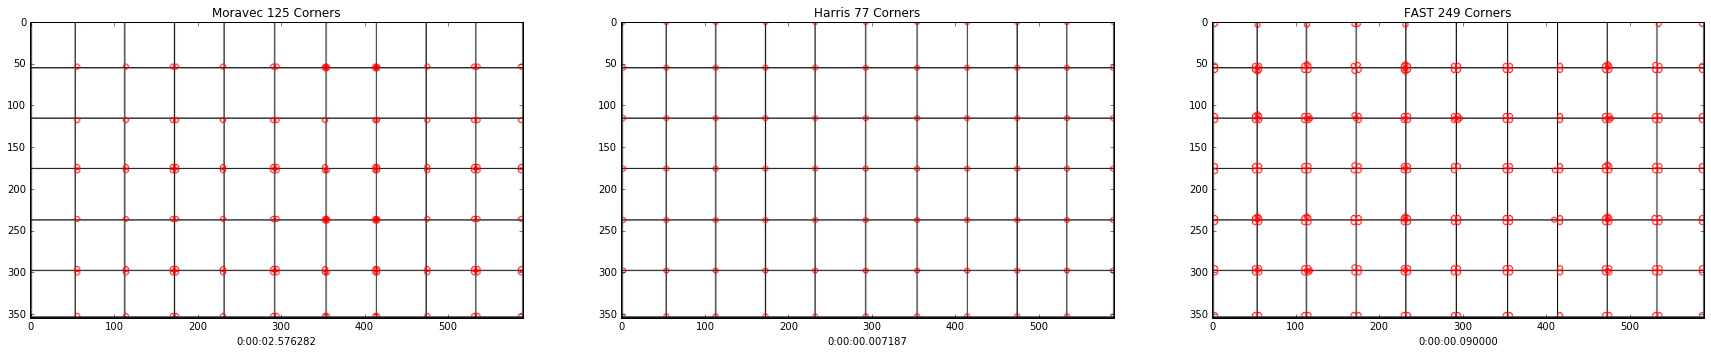

In [9]:
img_file = 'grid.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))
plt.figure(figsize = (8, 6))
# plt.imshow(origin_img)
kps, times = detect_all(gray_img, 0.25, 0.01, 10)
show_result(origin_img, kps, times, img_file)

width: 240, height: 300 
Moravec max = 20156
Harris max = 53196736.0
corners type is <type 'numpy.ndarray'>
Threshold: 70
nonmaxSuppression:True
neighborhood: 2


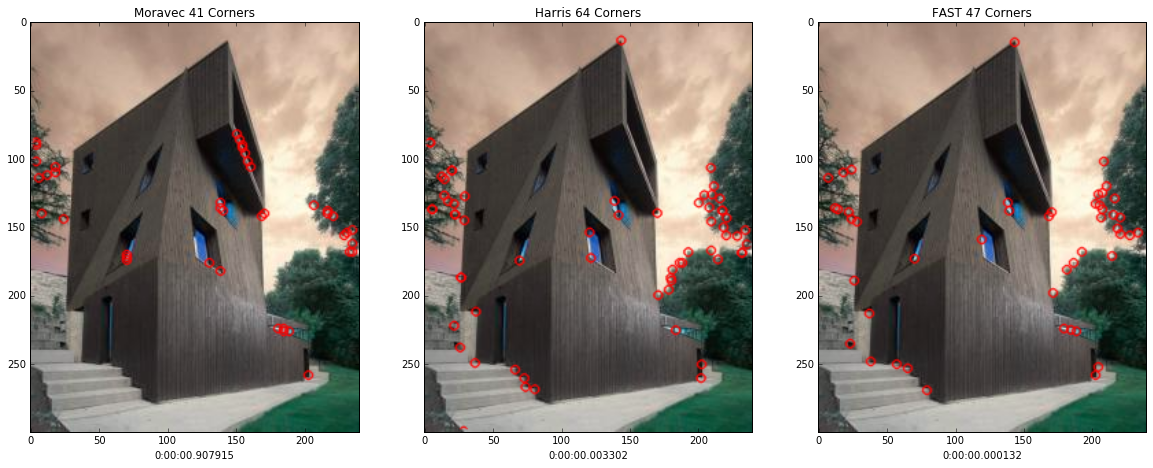

In [10]:
img_file = 'house.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))
plt.figure(figsize = (6, 4))
#plt.imshow(origin_img)
kps, times = detect_all(gray_img, 0.3, 0.05, 70)
show_result(origin_img, kps, times, img_file, 20, 8)

width: 400, height: 400 
Moravec max = 33757
Harris max = 56097328.0
corners type is <type 'numpy.ndarray'>
Threshold: 50
nonmaxSuppression:True
neighborhood: 2


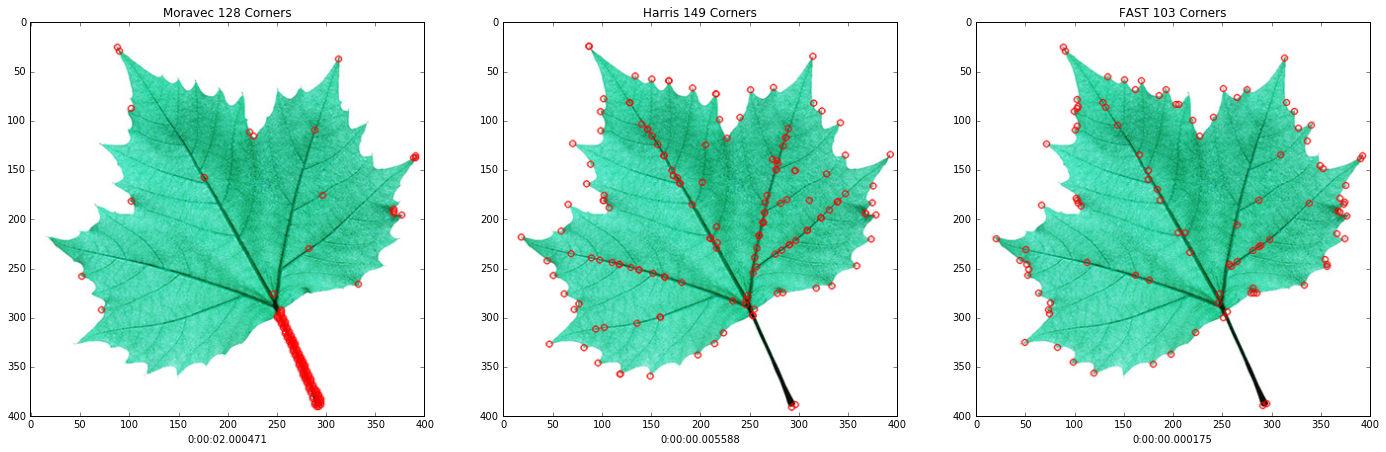

In [11]:
img_file = 'leaf.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))
plt.figure(figsize = (8, 6))
#plt.imshow(origin_img)
kps, times = detect_all(gray_img, 0.15, 0.01, 50)
show_result(origin_img, kps, times, img_file, 24, 12)

### Performance Evaluation

#### 1. Ground truth verification
#### 2. Accuracy
Corners should be detected as close as possible to their correct positions
#### 3. Repeatability under various transformations
k = Nm / Nc <br>
Nm: the number of corner matches (between the original image and the transformed image), 
Nc: the number of corners in the original image

width: 693, height: 304 


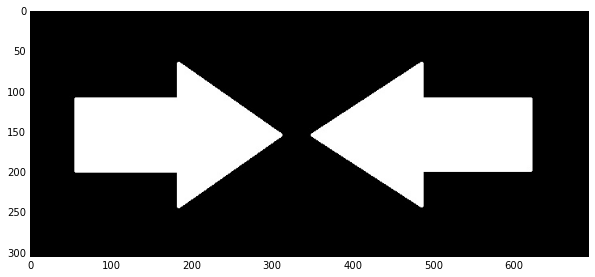

In [12]:
img_file = 'blackandwhite.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))
plt.figure(figsize = (10, 8))
plt.imshow(origin_img)

### 1. Original image

width: 693, height: 304 
Moravec max = 65042
Harris max = 458335776.0
corners type is <type 'numpy.ndarray'>
Threshold: 10
nonmaxSuppression:True
neighborhood: 2


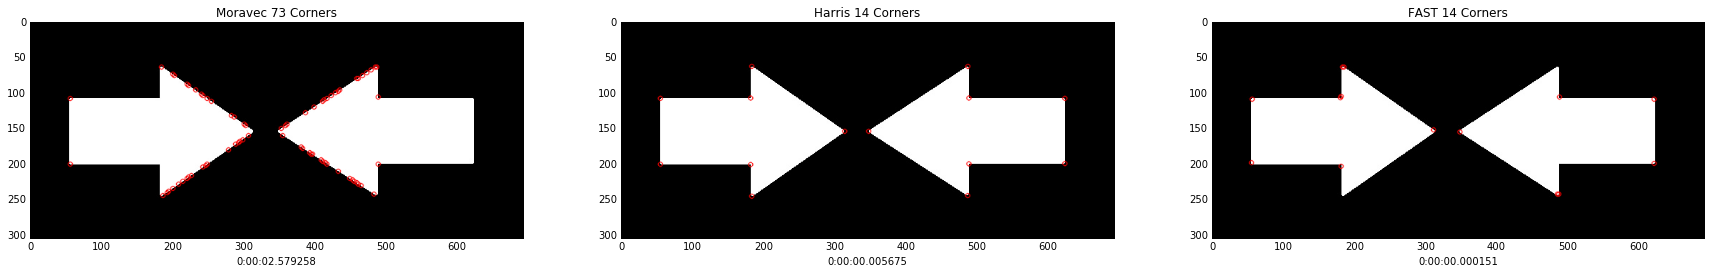

In [13]:
img_file = 'blackandwhite.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))
kps, times = detect_all(gray_img, 0.98, 0.01, 10)
show_result(origin_img, kps, times, img_file)

### 2. Rotate the image 30 degrees

In [14]:
img_file = 'blackandwhite-r30.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))

width: 753, height: 610 


Moravec max = 55484
Harris max = 286424928.0
corners type is <type 'numpy.ndarray'>
Threshold: 130
nonmaxSuppression:True
neighborhood: 2


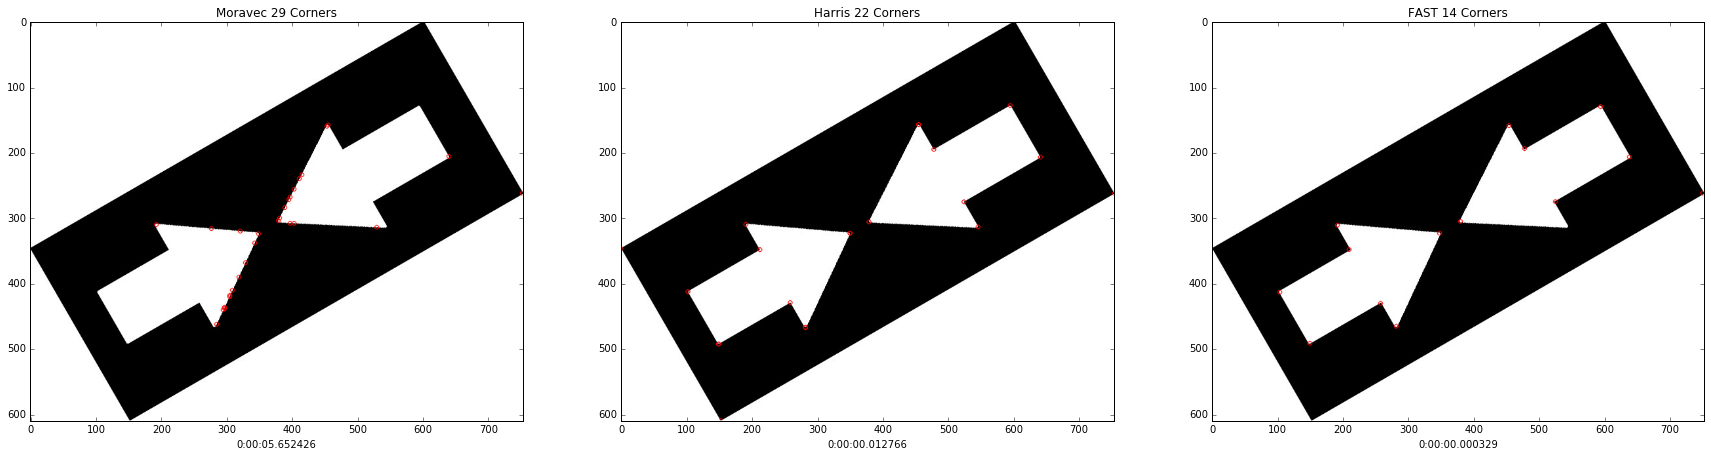

In [15]:
kps, times = detect_all(gray_img, 0.6, 0.09, 130)   
show_result(origin_img, kps, times, img_file)

### 3. Scale

In [16]:
img_file = 'blackandwhite-scale.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))

width: 347, height: 152 


Moravec max = 65026
Harris max = 497386976.0
corners type is <type 'numpy.ndarray'>
Threshold: 10
nonmaxSuppression:True
neighborhood: 2


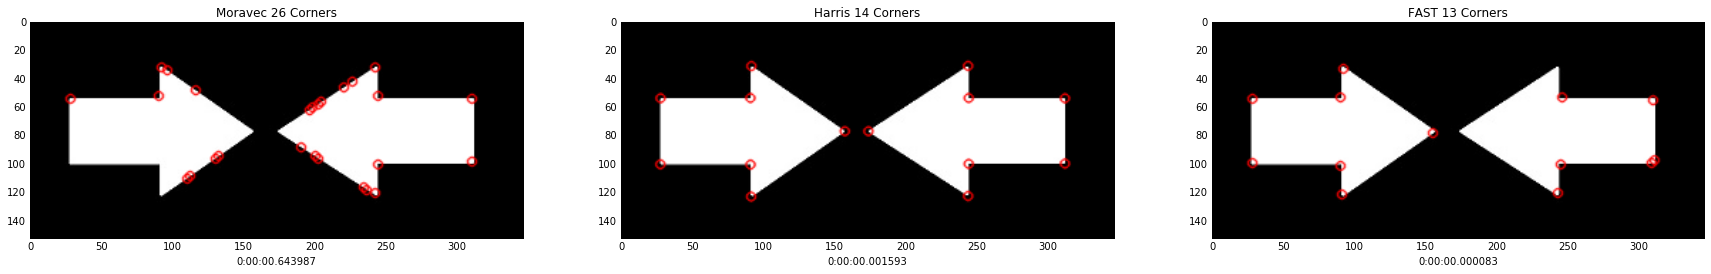

In [17]:
kps, times = detect_all(gray_img, 0.5, 0.01, 10)
show_result(origin_img, kps, times, img_file)

### 4. Add noise

In [18]:
img_file = 'blackandwhite.jpg'
origin_img, gray_img = load_img('img/{}'.format(img_file))
add_noise(origin_img)
cv2.imwrite("img/blackandwhite_pepper.jpg", origin_img)

width: 693, height: 304 


True

Moravec max = 65042
Harris max = 458335776.0
corners type is <type 'numpy.ndarray'>
Threshold: 1000
nonmaxSuppression:True
neighborhood: 2


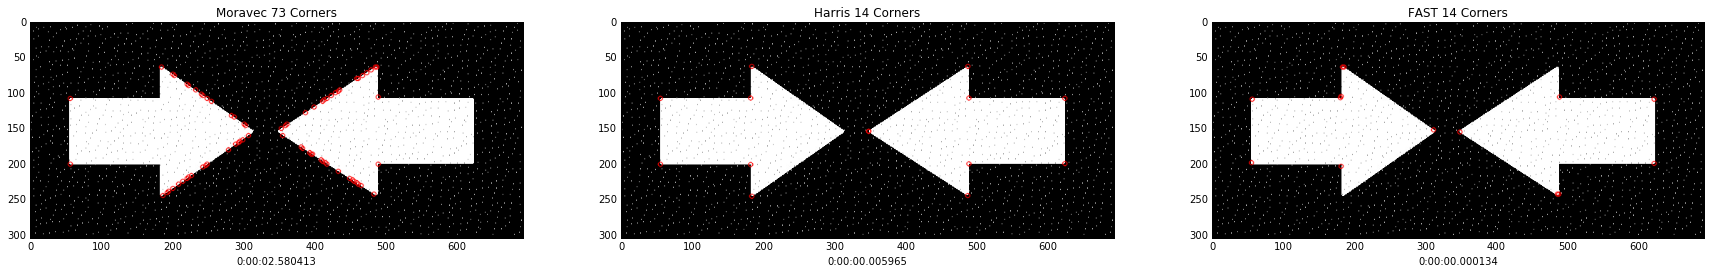

In [19]:
kps, times = detect_all(gray_img, 0.98, 0.15, 1000) 
show_result(origin_img, kps, times, img_file)

### Summary

* Harris may detect all correct corners in almost all cases
* FAST is the fatest algorithm, in our test, it is fater 17 to 43 times than Harris 
* Moravec is not comparble with FAST and Harris since it is implemented in python and has not done any optimization
* Moravec shows the worest performance among these three algorithms

## Application of corner detection

width: 1440, height: 1080 
width: 1440, height: 1080 


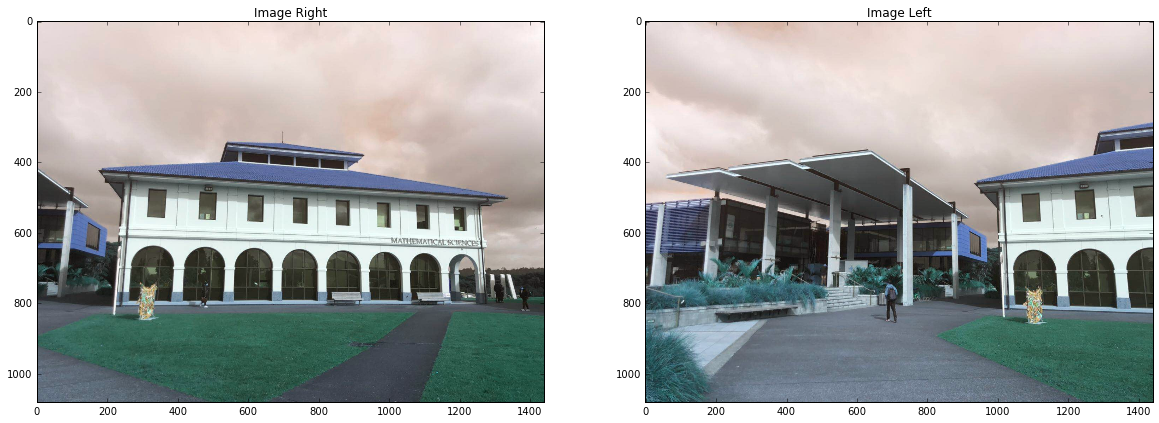

In [20]:
# img_name_l = "stiching1.jpg"
# img_name_r = "stiching2.jpg"
img_name_l = "Massey3.jpg"
img_name_r = "Massey1.jpg"
img_r, gray_r = load_img('img/{}'.format(img_name_r))
img_l, gray_l = load_img('img/{}'.format(img_name_l))

plt.figure(figsize = (20, 16))
plt.subplot(1, 2, 1)
plt.imshow(img_r)
plt.title("Image Right")
plt.subplot(1, 2, 2)
plt.imshow(img_l)
plt.title("Image Left")
plt.show()

#### Detect feature points from two images

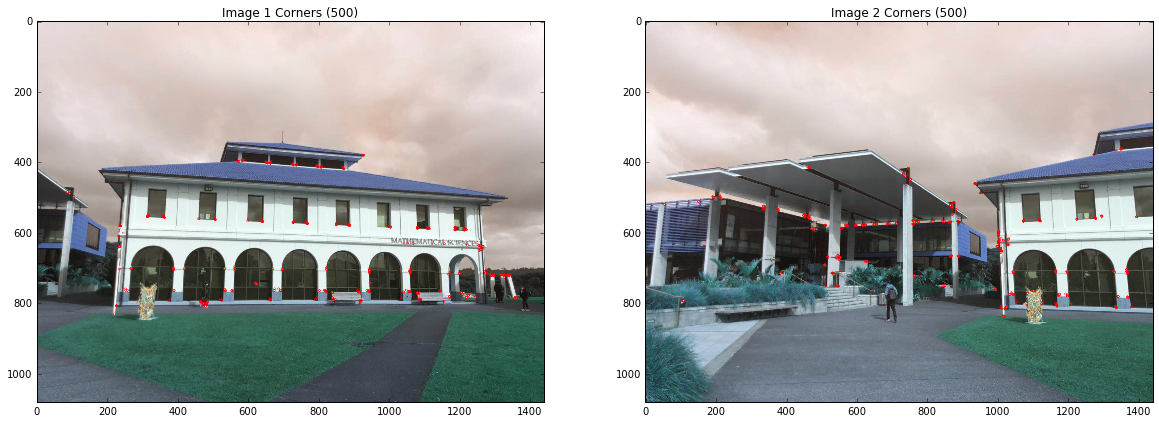

In [21]:
detector = cv2.ORB_create()
kp1, des1 = detector.detectAndCompute(gray_r, None)
kp2, des2 = detector.detectAndCompute(gray_l, None)

img_kp1 = cv2.drawKeypoints(img_r, kp1, None, color=(255, 0, 0))
img_kp2 = cv2.drawKeypoints(img_l, kp2, None, color=(255, 0, 0))

plt.figure(figsize = (20, 16))
plt.subplot(1, 2, 1)
plt.imshow(img_kp1, cmap='jet')
plt.title("Image 1 Corners ({})".format(len(kp1)))
plt.subplot(1, 2, 2)
plt.imshow(img_kp2, cmap='jet')
plt.title("Image 2 Corners ({})".format(len(kp2)))
plt.show()

#### Use kNN mather to find the correspondences and draw them
Estimate the homography using the correspondences, we typically use RANSAC to robustly estimate the homography because the correspondences will still likely contain a lot of noise.<br>
<b>Homography</b> is a transformation ( a 3×3 matrix ) that maps the points in one image to the corresponding points in the other image.

Find 104 match points


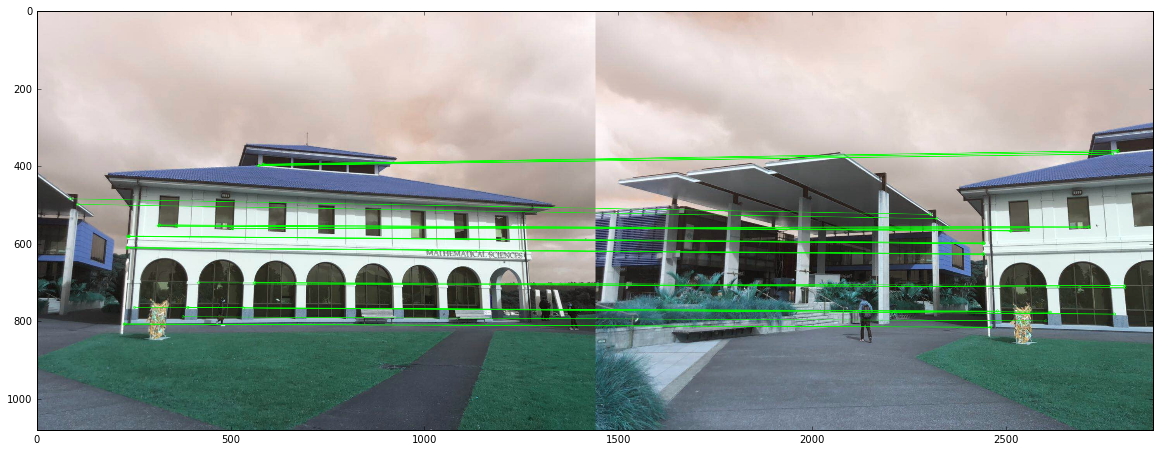

In [22]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
raw_matches = matcher.knnMatch(des1, des2, 2)
good_matches = []
for m,n in raw_matches:
    if m.distance < 0.8*n.distance:
        good_matches.append(m)

print('Find {} match points'.format(len(good_matches)))

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = matchesMask, 
                   flags = 2)# draw only inliers 

match_img = cv2.drawMatches(img_r, kp1, img_l, kp2, good_matches, None, **draw_params)   
plt.figure(figsize = (20, 16))
plt.imshow(match_img)
#cv2.imwrite("img/stiching_match.jpg", match_img)

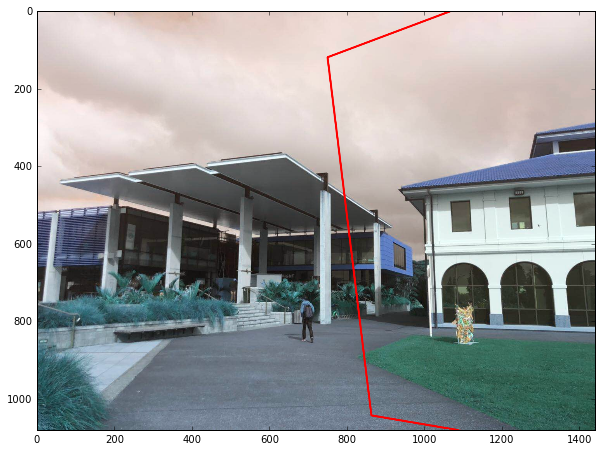

In [23]:
h = img_l.shape [0]
w = img_l.shape [1]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, H)
# show the overlapping area
img_l = cv2.polylines(img_l, [np.int32(dst)],True,255,3, cv2.LINE_AA)
plt.figure(figsize = (10, 8))
plt.imshow(img_l)

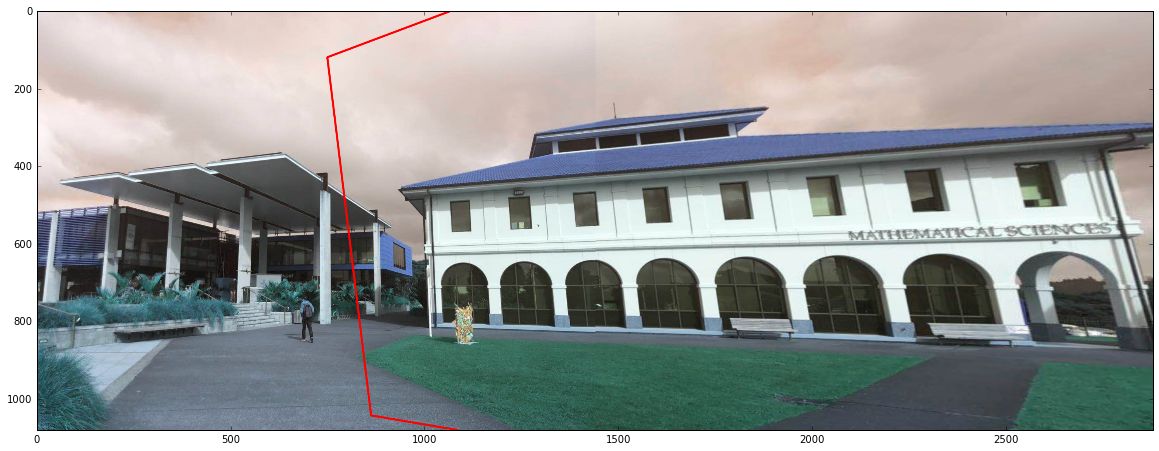

In [24]:
panorama = cv2.warpPerspective(img_r, H, (img_l.shape[1] + img_r.shape[1], img_l.shape[0]))
panorama[0:img_l.shape[0],0:img_l.shape[1]] = img_l
#plt.imshow(panorama)

def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.figure(figsize = (20, 16))
plt.imshow(trim(panorama))


### Reference

* https://docs.opencv.org/
* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_table_of_contents_core/py_table_of_contents_core.html#py-table-of-content-core
* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
* https://matplotlib.org/api/pyplot_summary.html
* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_tutorials.html
* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_fast/py_fast.html
* https://my-thistledown.com/2019/04/02/OpenCV-2/
* moravec https://blog.csdn.net/qq_20823641/article/details/52275543
* moravec with non-local maximum suppression https://blog.csdn.net/cp32212116/article/details/38390109
* https://pdfs.semanticscholar.org/e346/46460379b464ab4c62e37ffff2019d5d3228.pdf
* https://stackoverflow.com/questions/15838555/how-to-detect-corner-with-specific-angle-degree?rq=1
* https://answers.opencv.org/question/186538/to-find-the-coordinates-of-corners-detected-by-harris-corner-detection/
* http://richardt.name/teaching/supervisions/vision-2011/practical/
* Performance evaluation of corner detectors using consistency and accuracy measures https://www.sciencedirect.com/science/article/pii/S1077314205001852
* What is Homography https://www.learnopencv.com/homography-examples-using-opencv-python-c/
* https://pylessons.com/OpenCV-image-stiching-continue/
* https://stackoverflow.com/questions/17784810/stitching-final-size-and-offset